## Step 1: Import Libraries

In [1]:
"""
EXAMPLE1: Module-20-NLP/Class-3/Activities/03-Ins_Topic_Modeling_NMF/Solved/Non-Negative-Matrix-Factorization_solution.ipynb
Non-Negative Matrix Factorization(TDIFVectorizer) to Cluster headlines 

Example2: WK21-1/ 04-Ins_HuggingFace_Tokenizers_Similarity/
similarity_measures_solution
"""
import pandas as pd

# from nltk.sentiment import SentimentIntensityAnalyzer

# Disable truncation of long strings in pandas output
pd.set_option('display.max_colwidth', None)


## Load Parquet file function

In [2]:
import pandas as pd
import requests
from io import BytesIO

def load_parquet_from_url(url):
    """
    Downloads a Parquet file from a URL and loads it into a DataFrame.

    Parameters:
    - url (str): The URL to the Parquet file.

    Returns:
    - pd.DataFrame: The loaded DataFrame if successful, None otherwise.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises HTTPError if status is 4xx, 5xx
        file_stream = BytesIO(response.content)
        customer_reviews_df = pd.read_parquet(file_stream)
        print("File loaded successfully!")
        # display(customer_reviews_df.head())
        return customer_reviews_df
    except requests.exceptions.RequestException as e:
        print(f"Failed to download the file: {e}")
        return None
    except Exception as e:
        print(f"Failed to load the parquet file: {e}")
        return None

## Load Classified mood dataset:


In [3]:
# Load parquet file
url = "https://github.com/tlockhart/project-3/releases/download/v2.0/philly_reviews_with_mood.parquet"
customer_reviews_df = load_parquet_from_url(url)

File loaded successfully!


In [4]:
# Check Mood Value Counts:

mood_counts = customer_reviews_df["mood"].value_counts()
total_records_classified = customer_reviews_df["mood"].value_counts().sum()
# Print results
print("Mood Classification Breakdown:\n")
print(mood_counts)
print("Total Classified Records:", total_records_classified )

# Total number of records
total_records = len(customer_reviews_df)
print(f"Total Records: {total_records}")

# Verify that all records have been classified:
if total_records_classified == total_records:
    print(f"All records have been classified")
else:
    print(f"All records have not been classified")

Mood Classification Breakdown:

mood
indulgent      33956
cozy           29565
festive         6535
adventurous     3011
energizing       680
romantic         590
refreshing       275
comforting       206
Name: count, dtype: int64
Total Classified Records: 74818
Total Records: 74818
All records have been classified


In [5]:
# Loop through each unique mood and print 5 examples
for mood in customer_reviews_df["mood"].unique():
    print(f"\n***** {mood.upper()} REVIEWS *****")
    
    # Filter and get the first 5 samples
    samples = customer_reviews_df[customer_reviews_df["mood"] == mood].head(5)
    
    for i, text in enumerate(samples["review"], start=1):
        print(f"\n{i}. {text.strip()}")



***** INDULGENT REVIEWS *****

1. Beautiful clean shop with knock your socks off Everything ...
Homemade breakfast tarts and chicken pot pies .
All sweets looked well beyond beautiful and delish.
I felt some of the items were a tad pricey considering the sizes being on a smaller size. But I know premium quality costs more .. 
It's a great place for locals and worth a trip if traveling from center city etc .
I found counter staff to be most friendly and engaging 
Will be back and certainly will recommend

2. I moved from Chicago to Philadelphia over a year ago.  Everybody here raves about the restaurants, but I have yet to find many that deserve five stars, or even four.  This is the best restaurant I have eaten in in Philadelphia.  

Tahini and bread  arrived at the table, and I thought, hum, plain but I'm hungry.  They must put crack in that Tahini.  I wanted to lap it out of the bowl like an uncouth dog.  The bread is excellent too.

I love a menu with many organic meat choices.  Ho

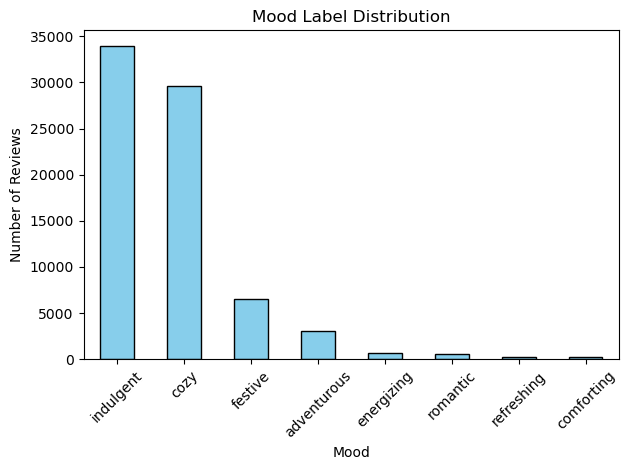

In [6]:
# Plot the mood counts
import matplotlib.pyplot as plt

mood_counts.plot(kind='bar', title='Mood Label Distribution', color='skyblue', edgecolor='black')
plt.xlabel("Mood")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Identify profile with the highest number of recommendations with the selected mood

In [7]:
import pandas as pd
import random

def recommend_restaurant_by_mood_content(df, mood, num_of_recommendations=5):
    """
    Recommends the best restaurant based on the selected mood using only 
    the reviews of the mood expert (content-based filtering).
    Adds randomness if multiple restaurants have the same top score.

    Parameters:
    - df: DataFrame containing review data.
    - mood: str, the mood selected by the user.
    - num_of_recommendations: int, how many top restaurants to return for inspection (default 5).

    Returns:
    - The best matching restaurant for the selected mood.
    """
    # Step 1: Filter reviews by selected mood
    mood_matches = df[df["mood"] == mood]

    if mood_matches.empty:
        print(f"No restaurants found for mood: {mood}")
        return None

    # Step 2: Find the user (mood expert) with the most reviews for this mood
    mood_expert_id = mood_matches["user_id"].value_counts().idxmax()
    
    # Step 3: Get mood expert's reviews for this mood
    mood_expert_reviews = mood_matches[mood_matches["user_id"] == mood_expert_id].copy()
    
    # Step 4: Add the count of mood expert's reviews (optional, for tracking)
    mood_expert_review_count = mood_matches["user_id"].value_counts().loc[mood_expert_id]
    mood_expert_reviews["mood_expert_review_count"] = mood_expert_review_count
    
    # Step 5: Truncate the "review" text to 50 characters for easier reading
    if "review" in mood_expert_reviews.columns:
        mood_expert_reviews["short_review"] = mood_expert_reviews["review"].apply(
            lambda x: x[:50] + "..." if isinstance(x, str) and len(x) > 50 else x
        )
    
    # Step 6: Sort by review_stars (highest first)
    mood_expert_reviews = mood_expert_reviews.sort_values(by="review_stars", ascending=False)

    # Step 7: Display only important fields
    display(mood_expert_reviews[[
        "business_name",
        "short_review",
        "review_stars",
        "mood_expert_review_count"
    ]].head(num_of_recommendations))

    # Step 8: Get top N restaurants
    top_recommendations = mood_expert_reviews.head(num_of_recommendations)

    # Step 9: Find the maximum review_stars
    max_score = top_recommendations["review_stars"].max()

    # Step 10: Filter only the ones with the top score
    top_scoring_restaurants = top_recommendations[top_recommendations["review_stars"] == max_score]

    # Step 11: Randomly select one if multiple restaurants have the same score
    final_best = top_scoring_restaurants.sample(1, random_state=random.randint(1, 9999)).iloc[0]

    return final_best[[
        "user_id",
        "business_name",
        "address",
        "city",
        "categories",
        "mood",
        "mood_expert_review_count",
        "review_stars"
    ]]

## Test Content-Based-Filtering: Select the restaurant, where the expert's friends have the most matching reviews


In [8]:
# User Input:
# user_selected_mood = "cozy"
# user_selected_mood = "indulgent"

# formated_restaurant = pd.DataFrame()
# final_recommendation = recommend_restaurant_by_mood_content(customer_reviews_df, user_selected_mood)

# if final_recommendation is not None:
#     print(f"Best Restaurant Recommendation for Mood '{user_selected_mood}':")
#     formated_restaurant = final_recommendation.to_frame().T
# else:
#     print("No recommendation found.")
# display(formated_restaurant)

## Create Pipeline with filtered reviews based on mood

In [9]:
def full_chain_recommendation(df, user_mood):
    """
    Full recommendation pipeline:
    1. Auto-label mood (if not already labeled)
    2. Filter restaurants by user mood
    3. Find best restaurant
    """

    if "mood" not in df.columns:
        print("Mood column not found. Auto-labeling reviews...")
        df["mood"] = df["review"].apply(assign_mood)

    print(f"🔍 Finding restaurants for mood: {user_mood}")

    best_restaurant = recommend_restaurant_by_mood_content(df, user_mood)

    if best_restaurant is not None:
        print("Recommended Restaurant:")
        display(pd.DataFrame([best_restaurant]))
    else:
        print("No recommendation could be made.")

    return best_restaurant

## Test Pipeline

In [11]:
# User Input:
# user_selected_mood = "cozy"
# user_selected_mood = "indulgent"
user_selected_mood = "romantic"
recommendation = full_chain_recommendation(customer_reviews_df, user_selected_mood)

🔍 Finding restaurants for mood: romantic


,business_name,short_review,review_stars,mood_expert_review_count
5040,Trattoria Carina,"(to the tune of ""Gorgeous"" by Taylor Swift)\n\nYou s...",5.0,4
46071,L'Angolo Ristorante,(to the tune of That's Amore by Dean Martin)\n\nWhen...,5.0,4
58288,Beiler's Bakery,"(To the tune of ""The Sign"" by Ace of Base)\n\nI, I'v...",5.0,4
71863,Wm Mulherin's Sons,"(to the tune of ""Bad at Love"" by Halsey)\n\nWhen I'm...",5.0,4


Recommended Restaurant:


,user_id,business_name,address,city,categories,mood,mood_expert_review_count,review_stars
46071,ryisT19-tzvMyVVi0iLvwA,L'Angolo Ristorante,1415 W Porter St,Philadelphia,"[Restaurants, Italian]",romantic,4,5.0
